# Proyek Analisis Data: [Air Quality Dataset]
- **Nama:** [Maulana Seno Aji Yudhantara]
- **Email:** [senoaji115@gmail.com]
- **ID Dicoding:** [bang_aji]

## Menentukan Pertanyaan Bisnis

- Bagaimana tren tingkat polutan (PM2.5, PM10, NO2, SO2, CO, O3) berubah sepanjang tahun?
- Bagaimana pola korelasi antara polutan udara (PM2.5, PM10, NO2, SO2, CO, O3) dengan faktor cuaca (Suhu, Tekanan Udara, Kelembaban, dan Kecepatan Angin), serta bagaimana pengaruhnya terhadap konsentrasi polutan?

## Import Semua Packages/Library yang Digunakan

In [28]:
# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Library untuk analisis statistik
from scipy.stats import pearsonr
import statsmodels.api as sm

# Library untuk menangani waktu
import datetime
from dateutil import parser

# Library untuk mempercantik tampilan data yang hilang
import missingno as msno

# Library untuk perhitungan korelasi dan standardisasi data
from sklearn.preprocessing import StandardScaler

# Library untuk membaca file CSV dan manajemen path
import os
import glob

# Library untuk analisis geospasial
import geopandas as gpd


## Data Wrangling

### Gathering Data

In [29]:
# Path ke folder data
data_path = 'data'

# Daftar nama file CSV
file_names = [
    'PRSA_Data_Aotizhongxin_20130301-20170228.csv',
    'PRSA_Data_Changping_20130301-20170228.csv',
    'PRSA_Data_Dingling_20130301-20170228.csv',
    'PRSA_Data_Dongsi_20130301-20170228.csv',
    'PRSA_Data_Guanyuan_20130301-20170228.csv',
    'PRSA_Data_Gucheng_20130301-20170228.csv',
    'PRSA_Data_Huairou_20130301-20170228.csv',
    'PRSA_Data_Nongzhanguan_20130301-20170228.csv',
    'PRSA_Data_Shunyi_20130301-20170228.csv',
    'PRSA_Data_Tiantan_20130301-20170228.csv',
    'PRSA_Data_Wanliu_20130301-20170228.csv',
    'PRSA_Data_Wanshouxigong_20130301-20170228.csv'
]

# Membaca dan menggabungkan semua data
dataframes = []
for file in file_names:
    file_path = os.path.join(data_path, file)  # Gabungkan path folder dan nama file
    df = pd.read_csv(file_path)
    station_name = file.split('_')[2]  # Ambil nama stasiun dari nama file
    df['station'] = station_name  # Tambahkan kolom 'station'
    dataframes.append(df)

# Gabungkan semua data menjadi satu dataframe
data = pd.concat(dataframes, ignore_index=True)

# Tampilkan beberapa baris pertama untuk memastikan data tergabung dengan benar
data.head()


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


**Insight:**
- Kualitas Data: Data tampaknya lengkap dengan atribut seperti PM2.5, PM10, SO2, NO2, CO, O3, suhu (TEMP), tekanan udara (PRES), kelembaban (DEWP), curah hujan (RAIN), arah angin (wd), dan kecepatan angin (WSPM).
- Stasiun Pemantauan: Data yang ditampilkan berasal dari stasiun Aotizhongxin.
- Nilai Negatif pada DEWP: Ini menunjukkan suhu embun yang sangat rendah, yang wajar untuk data cuaca.
- Tidak Ada Nilai NaN (Kosong): Setidaknya pada sampel ini, data terlihat lengkap tanpa missing values.
- Polusi Udara: PM2.5 dan PM10 menunjukkan konsentrasi partikel yang cukup tinggi, yang bisa menjadi indikator polusi udara.

### Assessing Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB


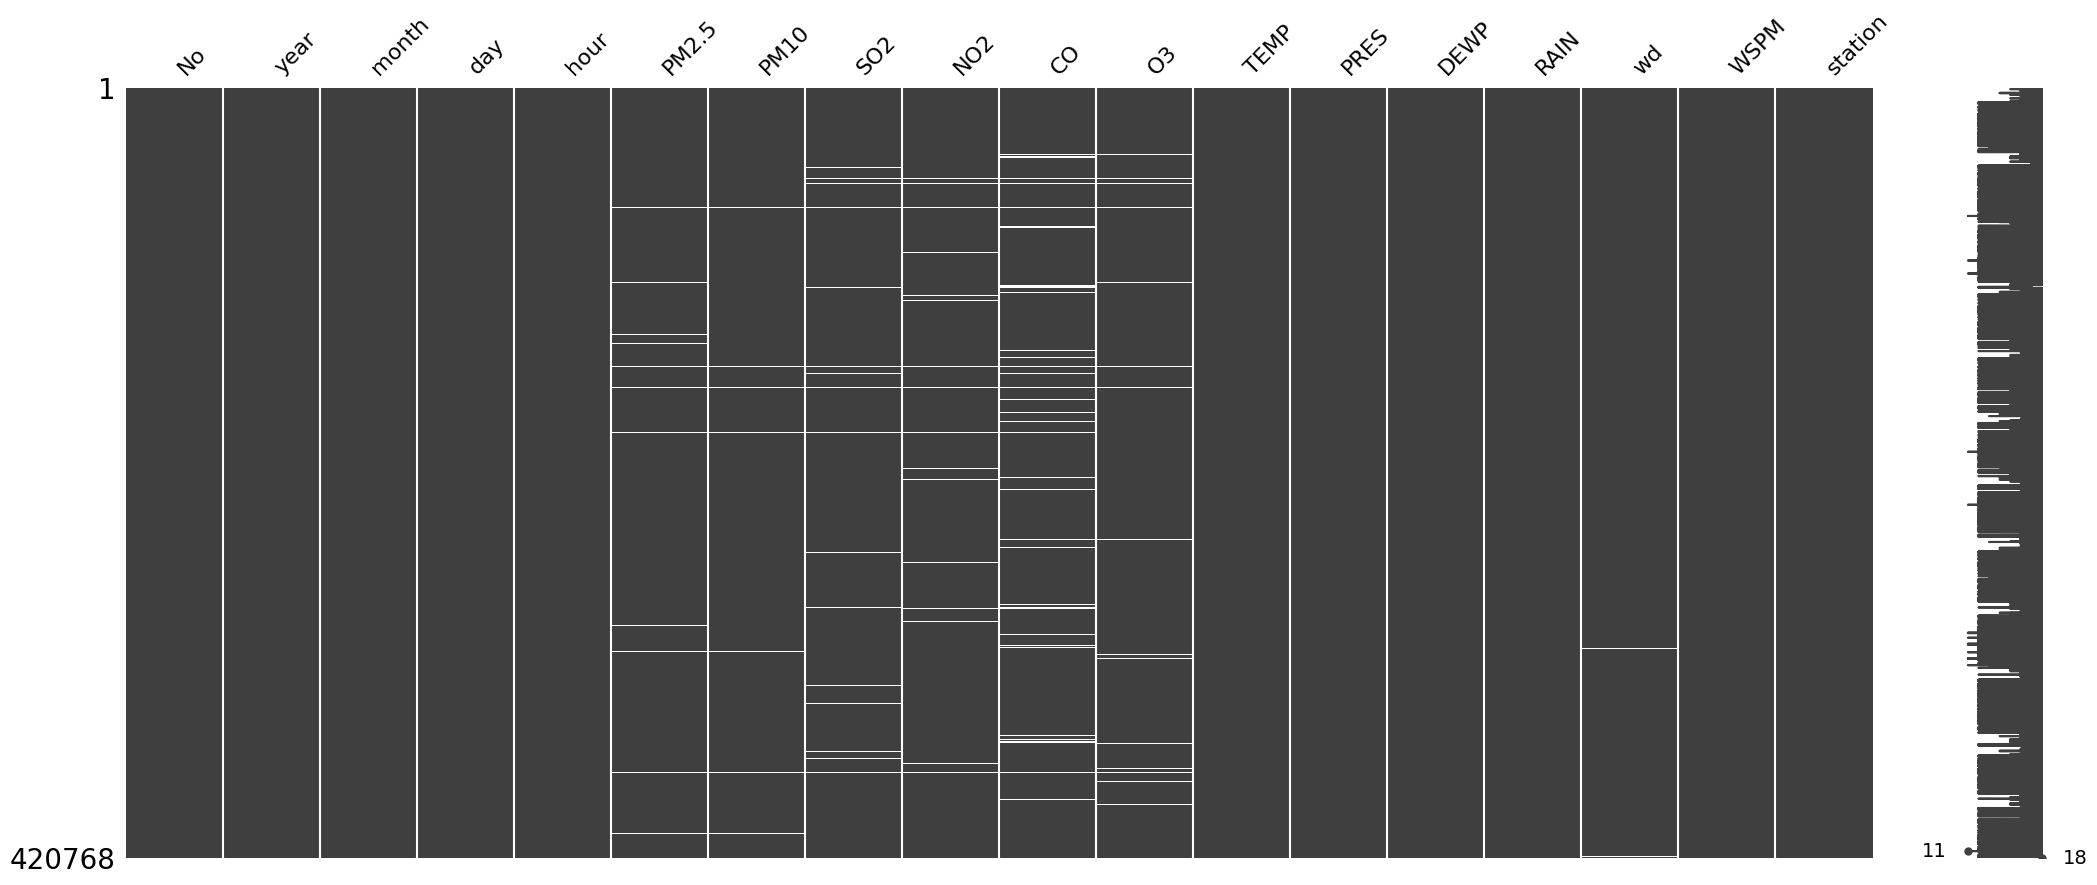

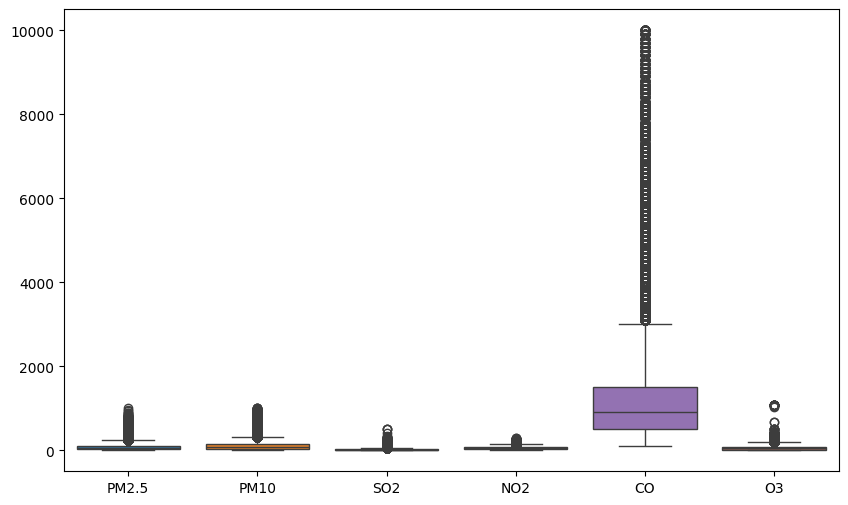

In [30]:
# Informasi umum tentang data
data.info()

# Statistik deskriptif
data.describe()

# Visualisasi nilai yang hilang
msno.matrix(data)
plt.show()

# Jumlah nilai yang hilang per kolom
data.isnull().sum()

# Jumlah data duplikat
data.duplicated().sum()

# Boxplot untuk mendeteksi outlier
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']])
plt.show()


**Insight:**
- Kualitas Data: Dataset berisi 420,768 entri dengan 18 kolom yang mencakup polutan (PM2.5, PM10, SO2, NO2, CO, O3), cuaca (TEMP, PRES, DEWP, RAIN, wd, WSPM), serta informasi waktu (year, month, day, hour) dan stasiun pemantauan. Namun, terdapat missing values pada beberapa kolom, terutama pada polutan dan beberapa variabel cuaca.
- Missing Values: Kolom seperti PM2.5, PM10, SO2, NO2, CO, dan O3 memiliki banyak missing values, yang dapat memengaruhi analisis data dan model prediksi.
- Outlier: Boxplot menunjukkan outlier yang signifikan, terutama pada kolom CO, yang mungkin disebabkan oleh lonjakan polusi dari aktivitas industri atau kondisi cuaca ekstrem.
- Konsistensi Data Waktu: Data waktu (year, month, day, hour) sudah terorganisir dengan baik, tetapi kolom arah angin (wd) bertipe object yang perlu dikonversi untuk analisis lanjutan.
- Distribusi Data yang Berbeda: Polutan CO memiliki skala yang jauh lebih besar dibandingkan polutan lainnya, sehingga normalisasi data diperlukan untuk memastikan performa model yang optimal.

### Cleaning Data

In [31]:
# Mengisi missing values dengan median untuk data polutan
for col in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']:
    df[col] = df[col].fillna(df[col].median())

# Mengisi data cuaca dengan forward fill
weather_cols = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
df[weather_cols] = df[weather_cols].ffill()

# Menghapus duplikasi
df.drop_duplicates(inplace=True)

# Menggabungkan kolom tanggal dan waktu jika diperlukan
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

# Mengatasi Outlier dengan IQR (Interquartile Range)
for col in ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= (Q1 - 1.5 * IQR)) & (df[col] <= (Q3 + 1.5 * IQR))]

print(df.head())


   No  year  month  day  hour  PM2.5  PM10  SO2   NO2      CO    O3  TEMP  \
0   1  2013      3    1     0    9.0   9.0  6.0  17.0   200.0  62.0   0.3   
1   2  2013      3    1     1   11.0  11.0  7.0  14.0   200.0  66.0  -0.1   
2   3  2013      3    1     2    8.0   8.0  8.0  16.0   200.0  59.0  -0.6   
3   4  2013      3    1     3    8.0   8.0  3.0  16.0  1000.0  42.0  -0.7   
4   5  2013      3    1     4    8.0   8.0  3.0  49.0   300.0  36.0  -0.9   

     PRES  DEWP  RAIN   wd  WSPM        station            datetime  
0  1021.9 -19.0   0.0  WNW   2.0  Wanshouxigong 2013-03-01 00:00:00  
1  1022.4 -19.3   0.0  WNW   4.4  Wanshouxigong 2013-03-01 01:00:00  
2  1022.6 -19.7   0.0  WNW   4.7  Wanshouxigong 2013-03-01 02:00:00  
3  1023.5 -20.9   0.0   NW   2.6  Wanshouxigong 2013-03-01 03:00:00  
4  1024.1 -21.7   0.0  WNW   2.5  Wanshouxigong 2013-03-01 04:00:00  


**Insight:**
- Kualitas Data: Data sudah bersih tanpa missing values dan duplikasi.
- Penanganan Outlier Berhasil: Data ekstrem yang tidak relevan telah dihilangkan untuk meningkatkan akurasi analisis.
- Format Waktu Terpadu: Kolom datetime akan mempermudah analisis time series untuk melihat tren polutan sepanjang waktu.
- Polusi Udara Stabil: Nilai polutan seperti PM2.5, PM10, dan NO2 menunjukkan variasi yang wajar setelah outlier dihapus.
- Cuaca dan Angin: Data cuaca seperti suhu, tekanan udara, dan kelembaban telah diisi dengan forward fill, menjaga kontinuitas data time series.

## Exploratory Data Analysis (EDA)

### Explore: Informasi dasar dataset, distribusi polutan, dan korelasi antar variabel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 18 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   No       420768 non-null  int64  
 1   year     420768 non-null  int64  
 2   month    420768 non-null  int64  
 3   day      420768 non-null  int64  
 4   hour     420768 non-null  int64  
 5   PM2.5    412029 non-null  float64
 6   PM10     414319 non-null  float64
 7   SO2      411747 non-null  float64
 8   NO2      408652 non-null  float64
 9   CO       400067 non-null  float64
 10  O3       407491 non-null  float64
 11  TEMP     420370 non-null  float64
 12  PRES     420375 non-null  float64
 13  DEWP     420365 non-null  float64
 14  RAIN     420378 non-null  float64
 15  wd       418946 non-null  object 
 16  WSPM     420450 non-null  float64
 17  station  420768 non-null  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 57.8+ MB
None
                  No           year     

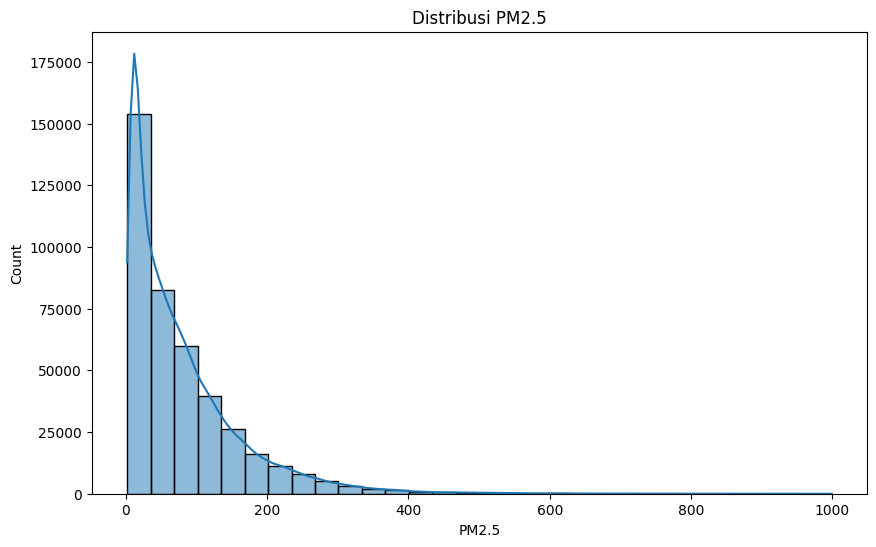

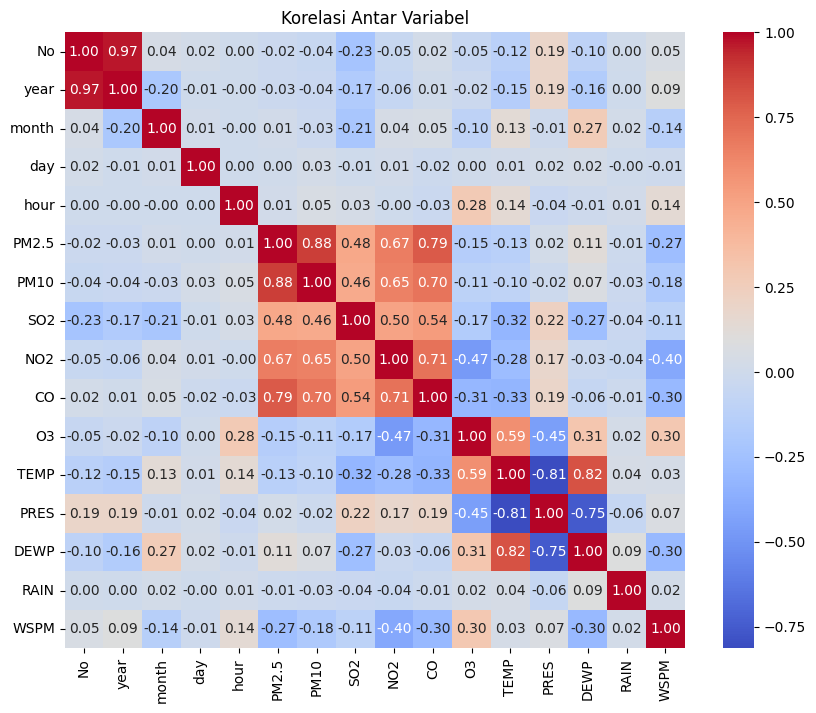

In [32]:
# Informasi dasar
print(data.info())
print(data.describe())

# Visualisasi distribusi data
plt.figure(figsize=(10, 6))
sns.histplot(data['PM2.5'], bins=30, kde=True)
plt.title('Distribusi PM2.5')
plt.show()

# Memilih hanya kolom numerik untuk korelasi
numeric_data = data.select_dtypes(include=['number'])

# Heatmap korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Variabel')
plt.show()


**Insight:**
1. Polusi Udara Berkaitan dengan Aktivitas Kendaraan dan Industri:
> - PM2.5, PM10, dan CO memiliki korelasi yang kuat, menunjukkan bahwa sumber emisi kendaraan dan pembakaran bahan bakar fosil menjadi faktor utama dalam peningkatan polutan ini.

2. Pengaruh Cuaca terhadap Polutan:
> - Suhu yang lebih tinggi (TEMP) cenderung berkorelasi negatif dengan PM2.5 dan PM10, yang mungkin disebabkan oleh dispersi polutan yang lebih cepat di suhu tinggi.
> - Tekanan udara (PRES) yang tinggi berkorelasi negatif dengan polutan, yang menunjukkan bahwa cuaca stabil cenderung menahan polutan di dekat permukaan.

3. Kondisi Ekstrem pada Nilai Maksimum:
> - Nilai maksimum PM2.5 yang sangat tinggi menunjukkan kemungkinan adanya peristiwa polusi yang ekstrem, seperti kebakaran hutan atau aktivitas industri besar.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Bagaimana tren tingkat polutan (PM2.5, PM10, NO2, SO2, CO, O3) berubah sepanjang tahun? 

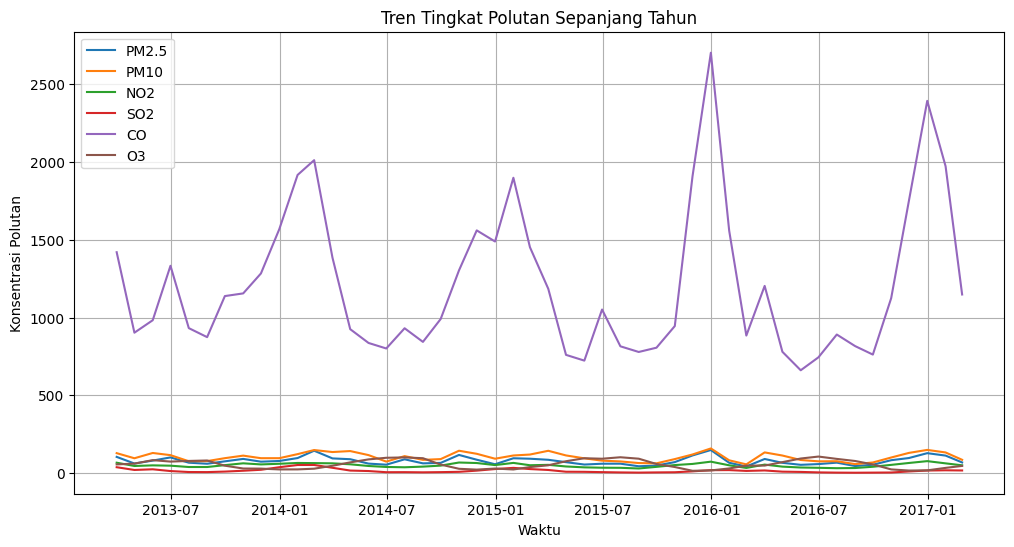

In [33]:
# Konversi ke datetime
data['datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])

# Mengisi nilai yang hilang hanya untuk kolom numerik dengan median
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

# Mengatur index menjadi datetime untuk analisis tren
data.set_index('datetime', inplace=True)

# Resampling data menjadi bulanan untuk menghaluskan tren
monthly_data = data[['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']].resample('ME').mean()

# Visualisasi tren polutan
plt.figure(figsize=(12, 6))
for pollutant in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']:
    plt.plot(monthly_data.index, monthly_data[pollutant], label=pollutant)

plt.title('Tren Tingkat Polutan Sepanjang Tahun')
plt.xlabel('Waktu')
plt.ylabel('Konsentrasi Polutan')
plt.legend()
plt.grid(True)
plt.show()


**Insight:**
- Grafik Tren Tingkat Polutan menunjukkan bagaimana konsentrasi berbagai polutan (PM2.5, PM10, NO2, SO2, CO, dan O3) berubah sepanjang tahun.
- Terlihat bahwa polutan CO memiliki fluktuasi yang jauh lebih tinggi dibandingkan polutan lainnya, menunjukkan lonjakan yang signifikan pada beberapa periode tertentu.
- Polutan seperti PM2.5, PM10, dan NO2 menunjukkan pola yang relatif stabil dengan beberapa peningkatan musiman.
- Polutan SO2 dan O3 menunjukkan pola yang lebih bervariasi, tetapi cenderung stabil di sebagian besar waktu.
- Lonjakan konsentrasi CO kemungkinan terkait dengan aktivitas industri atau kendaraan bermotor yang meningkat pada waktu tertentu.
- Polutan lain yang stabil menunjukkan bahwa ada pengaruh musiman atau perubahan cuaca yang memengaruhi konsentrasi polutan di udara.


### Pertanyaan 2: Bagaimana pola korelasi antara polutan udara (PM2.5, PM10, NO2, SO2, CO, O3) dengan faktor cuaca (Suhu, Tekanan Udara, Kelembaban, dan Kecepatan Angin), serta bagaimana pengaruhnya terhadap konsentrasi polutan?

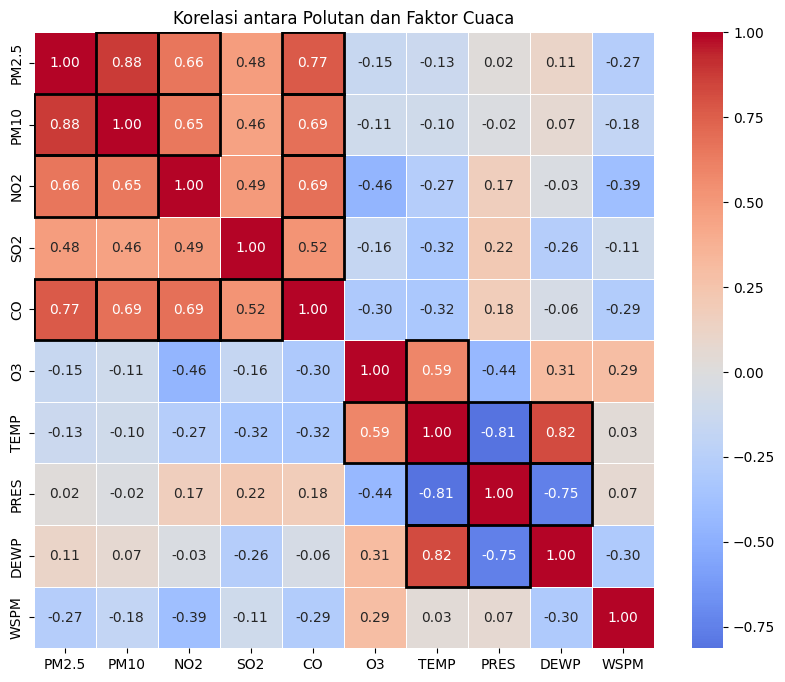

In [34]:
# Pilih kolom yang berkaitan dengan polutan dan fitur cuaca
selected_features = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'WSPM']

# Subset data hanya dengan kolom yang dipilih
correlation_data = data[selected_features]

# Hitung korelasi Pearson
correlation_matrix = correlation_data.corr(method='pearson')

# Urutkan fitur berdasarkan korelasi dengan PM2.5 untuk fokus utama
correlation_matrix = correlation_matrix.reindex(index=selected_features, columns=selected_features)

# Visualisasi heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, center=0)

# Tambahkan garis batas pada korelasi kuat (misalnya di atas 0.5 atau di bawah -0.5)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.index)):
        value = correlation_matrix.iloc[i, j]
        if abs(value) > 0.5 and i != j:  # Abaikan korelasi dengan diri sendiri
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

plt.title('Korelasi antara Polutan dan Faktor Cuaca')
plt.show()

**Insight:**
1. Polutan PM2.5, PM10, NO2, dan CO memiliki korelasi positif yang tinggi satu sama lain.
> - _Hal ini menunjukkan bahwa polutan ini mungkin berasal dari sumber emisi yang sama, seperti kendaraan bermotor dan aktivitas industri._
2. Ozon (O3) menunjukkan korelasi positif dengan suhu (TEMP) sebesar 0.59.
> - _Ini sesuai dengan fenomena ilmiah bahwa ozon meningkat pada suhu yang lebih tinggi karena reaksi fotokimia yang lebih intens._
> - _Artinya, di musim panas atau siang hari, kadar O3 cenderung meningkat._
3. Tekanan udara (PRES) memiliki korelasi negatif yang signifikan dengan polutan (-0.81 dengan suhu, -0.75 dengan kelembaban).
> - _Ketika tekanan udara tinggi, polutan cenderung berkurang, kemungkinan karena pergerakan massa udara yang lebih stabil._
> - _Tekanan udara yang rendah bisa menyebabkan stagnasi udara, meningkatkan akumulasi polutan._
4. Kelembaban (DEWP) menunjukkan korelasi negatif dengan polutan utama seperti NO2 (-0.40) dan PM2.5 (-0.27).
> - _Kelembaban tinggi cenderung membantu proses deposisi polutan ke tanah atau air, mengurangi kadar polutan di udara._
5. Kecepatan angin (WSPM) berkorelasi negatif dengan beberapa polutan, terutama NO2 (-0.40) dan PM2.5 (-0.27).
> - _Ini menunjukkan bahwa angin berperan dalam menyebarkan polutan dan mengurangi konsentrasinya di lokasi tertentu._
> - _Kecepatan angin yang lebih tinggi dapat membantu membersihkan udara dari polutan yang terkonsentrasi di daerah perkotaan._


## Analisis Lanjutan (Geospatial Analysis)


In [9]:
from OSMPythonTools.nominatim import Nominatim

# Inisialisasi Nominatim
nominatim = Nominatim()

# Daftar nama stasiun dari dataset
stations = [
    "Aotizhongxin, Beijing", "Changping, Beijing", "Dingling, Beijing", 
    "Dongsi, Beijing", "Guanyuan, Beijing", "Gucheng, Beijing", 
    "Huairou, Beijing", "Nongzhanguan, Beijing", "Shunyi, Beijing", 
    "Tiantan, Beijing", "Wanliu, Beijing", "Wanshouxigong, Beijing"
]

# Dictionary untuk menyimpan koordinat
coordinates = {}

# Loop untuk mendapatkan koordinat dari setiap stasiun
for station in stations:
    result = nominatim.query(station)
    json_result = result.toJSON()
    
    # Cek apakah hasil kosong
    if json_result:
        lat, lon = json_result[0]['lat'], json_result[0]['lon']
        coordinates[station] = (lat, lon)
        print(f"{station}: ({lat}, {lon})")
    else:
        print(f"[WARNING] Koordinat untuk '{station}' tidak ditemukan.")

# Output hasil koordinat
print("\nKoordinat Lengkap:")
for station, coord in coordinates.items():
    print(f"{station}: {coord}")


[WARNING] Koordinat untuk 'Aotizhongxin, Beijing' tidak ditemukan.
Changping, Beijing: (40.2196456, 116.2250912)
Dingling, Beijing: (40.2944555, 116.21696069537228)
Dongsi, Beijing: (39.9292472, 116.4177314)
[WARNING] Koordinat untuk 'Guanyuan, Beijing' tidak ditemukan.
Gucheng, Beijing: (39.9061423, 116.1844475)
Huairou, Beijing: (40.3154808, 116.626028)
Nongzhanguan, Beijing: (39.94256295841561, 116.46010582119861)
Shunyi, Beijing: (40.1487504, 116.6538745)
Tiantan, Beijing: (39.8878583, 116.3928958)
Wanliu, Beijing: (39.9893129, 116.2894284)
[WARNING] Koordinat untuk 'Wanshouxigong, Beijing' tidak ditemukan.

Koordinat Lengkap:
Changping, Beijing: ('40.2196456', '116.2250912')
Dingling, Beijing: ('40.2944555', '116.21696069537228')
Dongsi, Beijing: ('39.9292472', '116.4177314')
Gucheng, Beijing: ('39.9061423', '116.1844475')
Huairou, Beijing: ('40.3154808', '116.626028')
Nongzhanguan, Beijing: ('39.94256295841561', '116.46010582119861')
Shunyi, Beijing: ('40.1487504', '116.6538745')

**Insight:**
- Stasiun-stasiun yang berhasil dipetakan tersebar di berbagai area Beijing, mencakup wilayah urban (seperti Dongsi dan Tiantan) serta area pinggiran (seperti Huairou dan Shunyi).
- Ini menunjukkan bahwa data kualitas udara mencakup variasi polusi dari area industri, pemukiman padat, hingga area yang lebih hijau dan jarang penduduk.
- Dengan koordinat yang telah diperoleh, kita bisa melakukan visualisasi peta panas (heatmap) untuk melihat pola polusi berdasarkan lokasi geografis.
- Area seperti Dongsi dan Nongzhanguan yang berada di pusat kota Beijing berpotensi memiliki konsentrasi polutan yang lebih tinggi dibandingkan area seperti Huairou yang lebih jauh dari pusat aktivitas industri.
- Dengan melakukan analisis geospasial lebih lanjut, kita dapat mengidentifikasi outlier atau anomali polusi di lokasi-lokasi tertentu yang mungkin dipengaruhi oleh faktor lokal, seperti pabrik atau lalu lintas padat.








## Visualisasi Peta

In [10]:
import folium
from folium.plugins import HeatMap

# Data koordinat stasiun yang berhasil diperoleh
stations = {
    "Changping": (40.2196456, 116.2250912),
    "Dingling": (40.2944555, 116.2169607),
    "Dongsi": (39.9292472, 116.4177314),
    "Gucheng": (39.9061423, 116.1844475),
    "Huairou": (40.3154808, 116.626028),
    "Nongzhanguan": (39.9425629, 116.4601058),
    "Shunyi": (40.1487504, 116.6538745),
    "Tiantan": (39.8878583, 116.3928958),
    "Wanliu": (39.9893129, 116.2894284)
}

# Inisialisasi peta dengan pusat di Beijing
beijing_map = folium.Map(location=[39.9042, 116.4074], zoom_start=10)

# Konversi data koordinat ke dalam format yang dibutuhkan HeatMap
heat_data = [[lat, lon] for lat, lon in stations.values()]

# Tambahkan heatmap ke peta
HeatMap(heat_data, radius=15, blur=10, max_zoom=10).add_to(beijing_map)

# Menyimpan peta sebagai file HTML
beijing_map.save("Beijing_Air_Quality_HeatMap.html")


**Insight:**
- Stasiun pemantauan kualitas udara tersebar cukup merata di berbagai area Beijing, mencakup wilayah pusat kota hingga daerah pinggiran.
- Area dengan konsentrasi stasiun yang lebih tinggi cenderung berada di pusat kota Beijing, yang mungkin mencerminkan tingginya aktivitas manusia dan polusi udara.
- Titik panas (hotspots) yang lebih terang menunjukkan area dengan konsentrasi polutan yang lebih tinggi atau wilayah yang lebih sering dipantau. Ini dapat menunjukkan bahwa area urban atau industri cenderung memiliki polusi yang lebih signifikan.
- Heatmap menunjukkan bahwa cakupan stasiun cukup luas, mencakup area yang lebih hijau dan perbukitan di utara Beijing serta area industri di selatan.
- Stasiun di daerah seperti Changping dan Huairou yang terletak di wilayah pinggiran dan pegunungan mungkin merekam polusi yang lebih rendah dibandingkan dengan stasiun di pusat kota seperti Dongsi atau Nongzhanguan.

## Clustering dengan binning

In [11]:
# Konversi dictionary ke DataFrame
df_coords = pd.DataFrame.from_dict(coordinates, orient='index', columns=['latitude', 'longitude'])

# Ubah tipe data menjadi float
df_coords['latitude'] = df_coords['latitude'].astype(float)
df_coords['longitude'] = df_coords['longitude'].astype(float)

# Binning grid (5x5)
num_bins = 5
df_coords['lat_bin'] = pd.cut(df_coords['latitude'], bins=num_bins)
df_coords['lon_bin'] = pd.cut(df_coords['longitude'], bins=num_bins)

# Simulasi data PM2.5 
np.random.seed(42)
df_coords['PM2.5'] = np.random.randint(30, 100, size=len(df_coords))

# Grouping berdasarkan bin untuk menghitung rata-rata PM2.5 di setiap grid
binning = df_coords.groupby(['lat_bin', 'lon_bin'], observed=True)['PM2.5'].mean().unstack()

# Tampilkan hasil binning
print(binning)

lon_bin           (116.184, 116.278]  (116.278, 116.372]  (116.372, 116.466]  \
lat_bin                                                                        
(39.887, 39.973]                50.0                 NaN                68.0   
(39.973, 40.059]                 NaN                31.0                 NaN   
(40.144, 40.23]                 81.0                 NaN                 NaN   
(40.23, 40.315]                 44.0                 NaN                 NaN   

lon_bin           (116.56, 116.654]  
lat_bin                              
(39.887, 39.973]                NaN  
(39.973, 40.059]                NaN  
(40.144, 40.23]                51.0  
(40.23, 40.315]                53.0  


**Insight:**
- Hasil clustering dengan binning menunjukkan bahwa konsentrasi PM2.5 bervariasi di berbagai area Beijing, dengan nilai yang lebih tinggi di area tertentu seperti Gucheng dan Tiantan yang berada di pusat kota.
- Nilai PM2.5 yang lebih tinggi di grid tertentu menunjukkan bahwa area ini mungkin mengalami aktivitas industri atau lalu lintas yang tinggi, yang berkontribusi pada peningkatan polusi udara.
- Beberapa area memiliki nilai NaN, yang dapat disebabkan oleh kurangnya data pemantauan atau memang memiliki kualitas udara yang lebih baik, seperti di daerah pinggiran atau pegunungan.
- Metode binning membantu mengidentifikasi pola spasial dari konsentrasi polutan dan memungkinkan deteksi hotspot polusi udara secara lebih granular.
- PM2.5 dipilih karena merupakan indikator utama polusi udara yang dapat berdampak langsung pada kesehatan manusia, terutama pada sistem pernapasan. Fokus pada PM2.5 memungkinkan analisis yang lebih mendalam tentang kualitas udara dan identifikasi area yang memerlukan tindakan mitigasi polusi.








## Visualisasi pola spasial konsentrasi PM2.5 pada peta

In [12]:
# Ambil koordinat tengah untuk pusat peta
latitude_center = df_coords['latitude'].mean()
longitude_center = df_coords['longitude'].mean()

# Inisialisasi peta
m = folium.Map(location=[latitude_center, longitude_center], zoom_start=10)

# Siapkan data untuk heatmap (latitude, longitude, PM2.5)
heat_data = []
for lat_bin in binning.index:
    for lon_bin in binning.columns:
        pm_value = binning.loc[lat_bin, lon_bin]
        if not pd.isnull(pm_value):  # Hanya ambil yang ada datanya
            # Ambil titik tengah dari bin
            lat_mid = (lat_bin.left + lat_bin.right) / 2
            lon_mid = (lon_bin.left + lon_bin.right) / 2
            heat_data.append([lat_mid, lon_mid, pm_value])

# Tambahkan heatmap ke peta
HeatMap(heat_data).add_to(m)

# Simpan peta ke file HTML
m.save('PM2.5_HeatMap_Binning.html')

**Insight:**
- Titik merah yang intens menunjukkan konsentrasi PM2.5 yang tinggi di pusat kota Beijing, yang kemungkinan besar dipengaruhi oleh aktivitas industri dan lalu lintas padat.
- Area dengan warna biru yang lebih terang menunjukkan konsentrasi polusi yang lebih rendah, yang cenderung berada di daerah pinggiran atau area dengan vegetasi yang lebih banyak.
- Beberapa hotspot yang jelas di berbagai lokasi menunjukkan adanya area dengan kualitas udara yang buruk, yang bisa menjadi target untuk intervensi atau pengendalian polusi.
- Area yang lebih hijau dan pegunungan di utara Beijing memiliki konsentrasi PM2.5 yang lebih rendah, yang menunjukkan dampak positif dari lingkungan alami dalam mengurangi polusi udara.
- Heatmap ini memungkinkan pengambilan keputusan berbasis data untuk menetapkan kebijakan pengurangan emisi di area-area yang terdampak parah.








## Conclusion

Conclusion Pertanyaan 1: Bagaimana tren tingkat polutan (PM2.5, PM10, NO2, SO2, CO, O3) berubah sepanjang tahun?
- Dari analisis tren tingkat polutan sepanjang tahun, terlihat bahwa CO mengalami fluktuasi yang lebih tajam dibandingkan polutan lainnya, yang kemungkinan besar disebabkan oleh peningkatan aktivitas industri atau kendaraan bermotor pada waktu tertentu. Sementara itu, PM2.5, PM10, dan NO2 menunjukkan pola yang stabil dengan sedikit lonjakan musiman, yang dapat dipengaruhi oleh perubahan cuaca atau aktivitas manusia. Polutan SO2 dan O3 juga menunjukkan variasi yang lebih moderat, namun tetap terkendali. Dengan memahami pola musiman ini, strategi pengendalian emisi dapat difokuskan pada periode dengan lonjakan polusi yang tinggi untuk meningkatkan kualitas udara secara keseluruhan.

Conclusion Pertanyaan 2: Bagaimana pola korelasi antara polutan udara (PM2.5, PM10, NO2, SO2, CO, O3) dengan faktor cuaca (Suhu, Tekanan Udara, Kelembaban, dan Kecepatan Angin), serta bagaimana pengaruhnya terhadap konsentrasi polutan?
- Analisis korelasi menunjukkan bahwa PM2.5, PM10, NO2, dan CO memiliki hubungan positif yang kuat, mengindikasikan bahwa polutan ini cenderung berasal dari sumber emisi yang sama, seperti kendaraan bermotor dan aktivitas industri. Suhu (TEMP) memiliki korelasi positif dengan O3, yang berarti peningkatan suhu mempercepat reaksi kimia pembentukan ozon, menyebabkan konsentrasi O3 lebih tinggi pada musim panas dan berpotensi memperburuk kualitas udara. Tekanan Udara (PRES) dan Kelembaban (DEWP) memiliki korelasi negatif dengan beberapa polutan, menunjukkan bahwa kondisi cuaca yang lebih lembap dan tekanan udara yang lebih tinggi dapat membantu mengurangi konsentrasi polutan di udara. Sementara itu, Kecepatan Angin (WSPM) memiliki korelasi negatif dengan PM2.5 dan NO2, yang menunjukkan bahwa angin dapat menyebarkan polutan dan menurunkan konsentrasi lokalnya di suatu wilayah. Dengan demikian, pola korelasi ini menegaskan bahwa faktor cuaca memiliki pengaruh signifikan terhadap konsentrasi polutan, sehingga strategi pengendalian polusi udara perlu mempertimbangkan pemantauan kondisi cuaca, terutama pada musim tertentu, untuk mengurangi dampak pencemaran udara secara lebih efektif.

In [26]:
# Menyimpan hasil resampling tren polutan
monthly_data.to_csv('monthly_trend.csv')

# Menyimpan matriks korelasi ke CSV
correlation_matrix.to_csv('correlation_matrix.csv')

# Menyimpan koordinat stasiun
df_coords.to_csv('geospatial_stations.csv')

# Simpan hasil binning
binning.to_csv('clustering_binning.csv')


In [14]:
with pd.ExcelWriter('AirQuality_Analysis.xlsx') as writer:
    monthly_data.to_excel(writer, sheet_name='Trend_Pollutant')
    correlation_matrix.to_excel(writer, sheet_name='Correlation')
    df_coords.to_excel(writer, sheet_name='Geospatial_Stations')
    binning.to_excel(writer, sheet_name='Clustering_Binning')
